# Bottleneck likelihood for global epistasis models
This Python Jupyter notebook deals with a technical point: how to calculate the log likelihoods for the [global epistasis models](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html).
Specifically, it explains and illustrates the "bottleneck likelihood" calculation method, which is a way of calculating the likelihoods of variant phenotypes given sequencing counts from deep mutational scanning experiments that are subject to substantial bottlenecks when going from the pre- to post-selection conditions.

## Motivation
The bottleneck likelihood is appropriate when most noise in the experiment comes from a bottleneck when passaging the library from the pre-selection to post-selection condition.
This will be the case when the total pre- and post-selection sequencing depths greatly exceed the number of variants that were physically passaged from the pre-selection library to the post-selection one.
At least in Bloom lab deep mutational scanning experiments, this condition is quite common.

When experimental bottlenecks are smaller than the sequencing depths, noise in the statistical estimation of the pre- and post-selection variant frequencies (which forms the basis for the Gaussian likelihood calculations of [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550)) is overwhelmed by the experimental noise associated with the bottlenecking.
Therefore, we can get more accurate calculations by focusing on making sure the likelihood calculation accounts for the bottlenecks.

## Mathematical definition
Let $n_v^{\text{pre}}$ and $n_v^{\text{post}}$ be the pre-selection and post-selection counts for variant $v$.
The estimated frequencies of the variant pre- and post-selection are

$$f_v^{\text{pre}} = \frac{n_v^{\text{pre}} + C}{\sum_{v'} \left(n_{v'}^{\text{pre}} + C\right)}$$

and

$$f_v^{\text{post}} = \frac{n_v^{\text{post}} + C}{\sum_{v'} \left(n_{v'}^{\text{post}} + C\right)}$$
        
where $C$ is a pseudocount which by default is 0.5.
Because the sequencing depth greatly exceeds the experiment bottleneck, we disregard statistical error in the estimation of $f_v^{\text{pre}}$ and $f_v^{\text{post}}$ and instead take these as exact measurements.

Let $N_{\text{bottle}}$ be the bottleneck when passaging the pre-selection library to the post-selection condition.
We require an external estimation of $N_{\text{bottle}}$, which can be done experimentally or by applying the `bottlenecks.estimateBottleneck` function to the wildtype variants in the library.
As mentioned above, we assume this bottleneck is much smaller than the sequencing depth (meaning that $N_{\text{bottle}} \ll \sum_{v} n_{v}^{\text{pre}}, \sum_{v} n_{v}^{\text{pre}}$).
Let $n_v^{\text{bottle}}$ be the number of variants $v$ that survive the bottleneck, with $N_{\text{bottle}} = \sum_v n_v^{\text{bottle}}$.
Note that $n_v^{\text{bottle}}$ is **not** an experimental observable.

After the bottleneck, selection will change the frequency of variant $v$ by an amount proportional to $2^{p\left(v\right)}$ where $p\left(v\right)$ is the observed phenotype of the variant.

So the frequency $f_v^{\text{post}}$ of a variant after selection is related to $n_v^{\text{bottle}}$ and $p\left(v\right)$ by:

$$
\begin{eqnarray}
f_v^{\text{post}} 
&=&
\frac{n_v^{\text{bottle}} 2^{p\left(v\right)}}
     {\sum_{v'=1}^V n_{v'}^{\text{bottle}} 2^{p\left(v'\right)}} \\
&\approx&
\frac{n_v^{\text{bottle}} 2^{p\left(v\right)}}
     {N_{\text{bottle}} \sum_{v'=1}^V f_{v'}^{\text{pre}} 2^{p\left(v'\right)}}, \\
\end{eqnarray}
$$

where the approximation on the second line involves assuming that although the bottleneck changes the frequency of individual variants, the mean population fitness after the bottleneck is the same as the mean population fitness before the bottleneck (in other words, assuming that $\sum_{v=1}^V f_v^{\text{pre}} 2^{p\left(v\right)} \approx \sum_{v=1}^V \frac{n_{v'}^{\text{bottle}}}{N_{\text{bottle}}} 2^{p\left(v\right)}$).
We can then solve the above equation for $n_v^{\text{bottle}}$ to yield:

$$ n_v^{\text{bottle}}
=
\frac{f_v^{\text{post}} N_{\text{bottle}} \sum_{v'=1}^V f_{v'}^{\text{pre}} 2^{p\left(v'\right)}}{2^{p\left(v\right)}}.$$

We also know that $n_v^{\text{bottle}}$ should be Poisson distributed with mean $N_{\text{bottle}} \times f_v^{\text{pre}}$.
In other words, 
$$
\Pr\left(n_v^{\text{bottle}} \mid N_{\text{bottle}}, f_v^{\text{pre}}\right) = \exp\left(-N_{\text{bottle}} f_v^{\text{pre}}\right) \frac{\left(N_{\text{bottle}} f_v^{\text{pre}}\right)^{n_v^{\text{bottle}}}}{\Gamma\left(n_v^{\text{bottle}} + 1\right)}
$$

where we have used the "continuous Poisson distribution" defined by [Ilenko (2013)](https://arxiv.org/abs/1303.5990) and [Abid and Mohammed (2016)](http://pubs.sciepub.com/ijdeaor/2/1/2/), but dropped the normalizing factor $c_{\lambda}$ from their equations as the likelihoods do not have to integrate to one.
In the above equation, $\Gamma$ is the [gamma function](https://en.wikipedia.org/wiki/Gamma_function).

So given values for $f_v^{\text{pre}}$, $f_v^{\text{post}}$, $p\left(v\right)$, and $N_{\text{bottle}}$, we can calculate the log likelihood for variant $v$ of the implied $n_v^{\text{bottle}}$ values as:

$$
\begin{eqnarray}
\mathcal{L}_v
&=&
\ln \left[\prod_{v=1}^V \exp\left(-N_{\text{bottle}} f_v^{\text{pre}}\right) \frac{\left(N_{\text{bottle}} f_v^{\text{pre}}\right)^{n_v^{\text{bottle}}}}{\Gamma\left(n_v^{\text{bottle}} + 1\right)}\right] \\
&=&
n_v^{\text{bottle}} \ln \left(N_{\text{bottle}} f_v^{\text{pre}}\right) - 
\ln \Gamma\left(n_v^{\text{bottle}} + 1\right) -
N_{\text{bottle}} f_v^{\text{pre}}.
\end{eqnarray}
$$
In practice, the $f_v^{\text{pre}}$ and $f_v^{\text{post}}$ values are calculated from the experimentally observed counts, and $N_{\text{bottle}}$ is extimated experimentally---so fitting involves maximizing the likelihood with respect to the model-predicted phenotypes $p\left(v\right)$.

Note also that the above formulation, the observed phenotypes $p\left(v\right)$ can be arbitrarily scaled by adding any constant.
So after fitting, we then re-scale them to set the observed phenotype of the wildtype to $p\left(\text{wt}\right) = 0$.

## Plotting bottleneck likelihood versus Gaussian likelihood
Here we will plot the bottleneck likelihood as a function of various parameters, and compare it to the more standard Gaussian log likelihood.

First, import the necessary Python modules:

In [1]:
import itertools
import math

import numpy

import pandas as pd

from plotnine import *

import scipy.special

In the plotting below, we don't include the pseudocounts.
We set plausible numbers for $f_v^{\text{pre}}$, and the mean enrichment $\sum_{v'=1}^V f_{v'}^{\text{pre}} 2^{p\left(v\right)}$.
We then consider what is the likelihood of observing various values of $f_v^{\text{post}}$:

In [2]:
f_pre_v = 1e-5
mean_enrichment = 2**(-0.2)
f_post_v = numpy.logspace(math.log10(f_pre_v / 100), math.log10(f_pre_v * 3), 100)

Now for a range of values of $N_{\text{bottle}}$ and $p\left(v\right)$ we compute the bottleneck log likelihood $\mathcal{L}_v$.
We also compute the [Gaussian log likelihood](https://jbloomlab.github.io/dms_variants/dms_variants.globalepistasis.html#gaussian-likelihood), denoted $\mathcal{G}_v$, under the assumption that the sequencing depth is $10^7$, which implies an expectation of 100 counts of the variant pre-selection.
The variances for the Gaussian log likelihood are calculated using the equation of [Otwinoski et al (2018)](https://www.pnas.org/content/115/32/E7550), both without ($\mathcal{G}_v$) and with $\mathcal{G}_v^{\text{HOC}}$ adding some "house of cards" epistasis:

In [3]:
tot_seq_depth = 1e7  # used for Gaussian log likelihood
epistasis_HOC = 0.5  # house of cards epistasis for Gaussian log likelihood
F_pre_wt = F_post_wt = 0.3  # wildtype frequencies for Gaussian log liklelihood

df = pd.DataFrame({},
                  columns=['N_bottle', 'p_v', 'f_post_v', 'L_v', 'G_v', 'G_v_HOC'])

for N_bottle, p_v in itertools.product([5e4, 1e5, 5e5, 1e6, 5e6],
                                       [-0.5, -0.1, 0, 0.1, 0.5]):
    
    # bottleneck log likelihood
    n_v_bottle = f_post_v * N_bottle * mean_enrichment / 2**p_v
    L_v = n_v_bottle * math.log(N_bottle * f_pre_v) -  scipy.special.loggamma(n_v_bottle + 1) - N_bottle * f_pre_v
    
    # Gaussian log likelihood
    c_v_pre = f_pre_v * tot_seq_depth
    c_v_post = f_post_v * tot_seq_depth
    c_wt_pre = F_pre_wt * tot_seq_depth
    c_wt_post = F_post_wt * tot_seq_depth
    var = 1 / c_v_pre + 1 / c_v_post + 1 / c_wt_pre + 1 / c_wt_post
    score = numpy.log(c_v_post / c_v_pre) - numpy.log(c_wt_post / c_wt_pre)
    G_v = scipy.stats.norm.logpdf(score, p_v, numpy.sqrt(var))
    G_v_HOC = scipy.stats.norm.logpdf(score, p_v, numpy.sqrt(var + epistasis_HOC))
    
    df = df.append(pd.DataFrame({'N_bottle': N_bottle,
                                 'p_v': p_v,
                                 'f_post_v': f_post_v,
                                 'L_v': L_v,
                                 'G_v': G_v,
                                 'G_v_HOC': G_v_HOC,
                                 }))

Below we plot all the log likelihoods.
The vertical line shows the pre-selection frequency ($f_v^{\text{pre}}$).
The values of $p\left(v\right)$ are faceted in columns (top labels), and the values of $N_{\text{bottle}}$ are faceted in rows (right labels).

Note that a bottleneck of $10^5$ corresponds to an expectation that one copy of the variant will get through.
As seen below, the bottleneck likelihood puts very little penalty on a low post-selection frequency ($f_v^{\text{post}}$ when there is a strong bottleneck, as there is a substantial chance the variant is randomly lost.
However, as $1 / N_{\text{bottle}}$ starts to exceed $f_v^{\text{pre}}$, then it becomes very unlikely the variant is lost to the bottleneck, so the penalty for low $f_v^{\text{post}}$ increases.
However, even with the bottleneck likelihood there is substantial penalty on very large $f_v^{\text{post}}$, as that requires selection and is unlikely to occur by bottlenecking alone. 

In contrast, the Gaussian likelihoods are totally insensitive to the bottleneck, and have the same behavior for every bottleneck.
When there is bottlenecking, they over-penalize low $f_v^{\text{post}}$, and when there is a small house-of-cards epistasis the Gaussian likelihoods have a strange multi-peak behavior due to the variance also getting larger for smaller values of $f_v^{\text{post}}$.

The below plots therefore make clear why in the presence of substantial amounts of bottlenecking, the bottleneck likelihood gives a more reasonable behavior than the Gaussian likelihood.

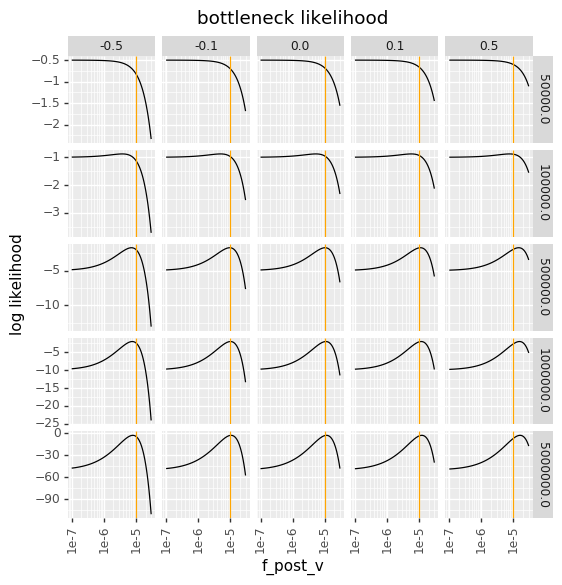

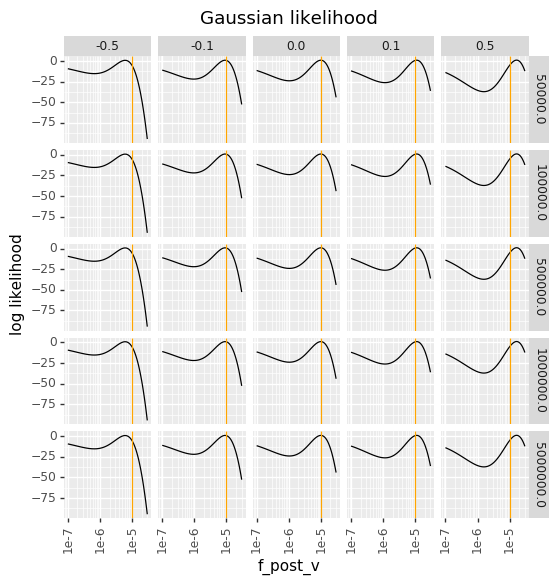

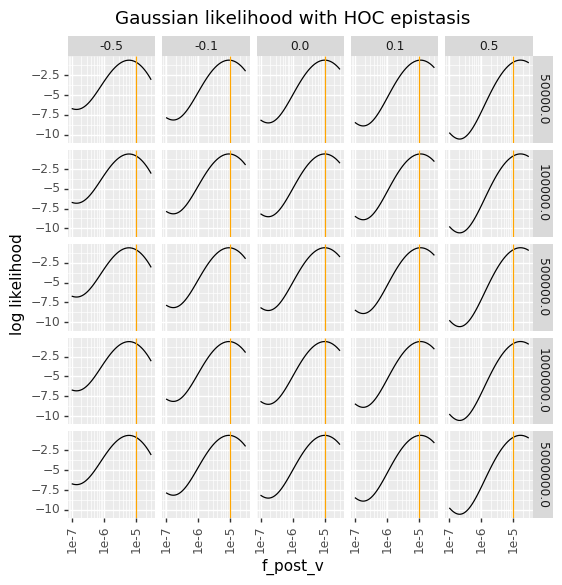

In [4]:
# NBVAL_IGNORE_OUTPUT
for loglik, title in [
        ('L_v', 'bottleneck likelihood'),
        ('G_v', 'Gaussian likelihood'),
        ('G_v_HOC', 'Gaussian likelihood with HOC epistasis')
        ]:
    p = (
     ggplot(df, aes('f_post_v', loglik)) +
     geom_path() + 
     facet_grid('N_bottle ~ p_v', scales='free_y') +
     scale_x_log10() +
     theme(figure_size=(6, 6),
           axis_text_x=element_text(angle=90)) +
     geom_vline(xintercept=f_pre_v, color='orange') +
     ylab('log likelihood') +
     ggtitle(title)
     )

    _ = p.draw()

The top plot above also makes clear why $N_{\text{bottle}}$ can't be a variable fit by maximum likelihood (at least until the formulation is generalized to use a multinomial rather than Poisson equation): the peaks of the bottleneck likelihood for each value of $N_{\text{bottle}}$ are sensible, but across different values of $N_{\text{bottle}}$ the smaller $N_{\text{bottle}}$ always yields a better "best" likelihood.